# ASOSAWOS Jumps Invgestigation

## Setup

In [1]:
#TODO: could use this as an alternative to multiple merges, for combining the subsets into the final output dataframe
from functools import reduce

import boto3
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import urllib
from datetime import datetime, timezone, date
#import datetime
import math
import shapely
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from io import BytesIO, StringIO
import scipy.stats as stats

import s3fs
import tempfile # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os
from shapely.geometry import Point
import time # Used for progress bar 
import sys # Used for progress bar 
import contextily as cx

# Silence warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Warning is raised when creating Point object from coords. 

In [ ]:
## Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client('s3') # for lower-level processes

## Set relative paths to other folders and objects in repository.
bucket_name = "wecc-historical-wx"
wecc_terr = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_land.shp"
wecc_mar = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_marine.shp"

: 

In [ ]:
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary 
temp_dir = "./tmp"
if not os.path.exists(temp_dir): 
    os.mkdir(temp_dir)

: 

In [ ]:
def progressbar(it, prefix="", size=60, out=sys.stdout): # Python3.6+
    """
    Print a progress bar to console 

    References
    ----------
    https://stackoverflow.com/questions/3160699/python-progress-bar
    
    """
    count = len(it)
    start = time.time() # time estimate start
    def show(j):
        x = int(size*j/count)
        # time estimate calculation and string
        remaining = ((time.time() - start) / j) * (count - j)        
        mins, sec = divmod(remaining, 60) # limited to minutes
        time_str = f"{int(mins):02}:{sec:03.1f}"
        print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count} Est wait {time_str}", end='\r', file=out, flush=True)
    show(0.1) # avoid div/0 
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

: 

In [ ]:
def read_nc_from_s3(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket 

    Parameters
    ----------
    network_name: str 
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")
    
    Returns 
    -------
    station_data: xr.Dataset 
    
    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file 
    I'd like to see us use a zarr workflow if possible to avoid this. 

    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir = temp_dir, 
        prefix = "", 
        suffix = ".nc",
        delete = True
    )

    # Create s3 file system 
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    #s3_url = 's3://wecc-historical-wx/3_qaqc_wx_dev/{}/{}.zarr'.format(network_name, station_id)
    s3_url = 's3://wecc-historical-wx/2_clean_wx/{}/{}.nc'.format(network_name, station_id)

    # Read in the data using xarray 
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine='h5netcdf').load()

    # Close temporary file 
    temp_file.close()

    return station_data 

: 

In [ ]:
def read_zarr_from_s3(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket 

    Parameters
    ----------
    network_name: str 
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")
    
    Returns 
    -------
    station_data: xr.Dataset 
    
    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file 
    I'd like to see us use a zarr workflow if possible to avoid this. 

    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir = temp_dir, 
        prefix = "", 
        suffix = ".zarr",
        delete = True
    )

    # Create s3 file system 
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    #s3_url = 's3://wecc-historical-wx/3_qaqc_wx_dev/{}/{}.zarr'.format(network_name, station_id)
    s3_url = 's3://wecc-historical-wx/2_clean_wx/{}/{}.zarr'.format(network_name, station_id)

    # Read in the data using xarray 
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine='zarr').load()

    # Close temporary file 
    temp_file.close()

    return station_data 

: 

In [ ]:
def qaqc_ds_to_df(ds, verbose=False):
    ## Add qc_flag variable for all variables, including elevation; 
    ## defaulting to nan for fill value that will be replaced with qc flag

    for key,val in ds.variables.items():
        if val.dtype==object:
            if key=='station':
                if str in [type(v) for v in ds[key].values]:
                    ds[key] = ds[key].astype(str)
            else:
                if str in [type(v) for v in ds.isel(station=0)[key].values]:
                    ds[key] = ds[key].astype(str)
                
    exclude_qaqc = ["time", "station", "lat", "lon", 
                    "qaqc_process", "sfcWind_method", 
                    "pr_duration", "pr_depth", "PREC_flag",
                    "rsds_duration", "rsds_flag", 
                    "anemometer_height_m",
                    "thermometer_height_m"
                   ] # lat, lon have different qc check

    raw_qc_vars = [] # qc_variable for each data variable, will vary station to station
    era_qc_vars = [] # our ERA qc variable
    old_era_qc_vars = [] # our ERA qc variable

    for var in ds.data_vars:
        if 'q_code' in var: 
            raw_qc_vars.append(var) # raw qc variable, need to keep for comparison, then drop
        if '_qc' in var: 
            raw_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop
        if '_eraqc' in var:
            era_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop
            old_era_qc_vars.append(var)

    print(f"era_qc existing variables:\n{era_qc_vars}")
    n_qc = len(era_qc_vars)
    
    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars and "_eraqc" not in var:
            qc_var = var + "_eraqc" # variable/column label

            # if qaqc var does not exist, adds new variable in shape of original variable with designated nan fill value
            if qc_var not in era_qc_vars:
                print(f"nans created for {qc_var}")
                ds = ds.assign({qc_var: xr.ones_like(ds[var])*np.nan})
                era_qc_vars.append(qc_var)
    
    print("{} created era_qc variables".format(len(era_qc_vars)-len(old_era_qc_vars)))
    if len(era_qc_vars)!=n_qc:    
        print("{}".format(np.setdiff1d(old_era_qc_vars, era_qc_vars)))
    
    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var:ds[var].attrs for var in list(ds.data_vars.keys())}

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df = ds.to_dataframe()

    # instrumentation heights
    if 'anemometer_height_m' not in df.columns:
        try:
            df['anemometer_height_m'] = np.ones(ds['time'].shape)*ds.anemometer_height_m
        except:
            print("Filling anemometer_height_m with NaN.", flush=True)
            df['anemometer_height_m'] = np.ones(len(df))*np.nan
        finally:
            pass
    if 'thermometer_height_m' not in df.columns:
        try:
            df['thermometer_height_m'] = np.ones(ds['time'].shape)*ds.thermometer_height_m
        except:
            print("Filling thermometer_height_m with NaN.", flush=True)
            df['thermometer_height_m'] = np.ones(len(df))*np.nan
        finally:
            pass

    # De-duplicate time axis
    df = df[~df.index.duplicated()].sort_index()
           
    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df['station'] = station
    
    # Station pd.Series to str
    station = station.unique().values[0]
    
    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()

    # Add time variables needed by multiple functions
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    df['day'] = pd.to_datetime(df['time']).dt.day 
    df['month'] = pd.to_datetime(df['time']).dt.month 
    df['year'] = pd.to_datetime(df['time']).dt.year 
    df['date']  = pd.to_datetime(df['time']).dt.date
    
    return df#, MultiIndex, attrs, var_attrs, era_qc_vars 

: 

## Load Data

In [ ]:
# load in single dc file from AWS
ds_1 = read_nc_from_s3('ASOSAWOS', 'ASOSAWOS_74948400395', temp_dir) 
ds_2 = read_nc_from_s3('ASOSAWOS', 'ASOSAWOS_74509023244', temp_dir) 
ds_3 = read_nc_from_s3('ASOSAWOS', 'ASOSAWOS_72494523293', temp_dir) 

#convert to formatted pandas dataframe
df_1 = qaqc_ds_to_df(ds_1, verbose=False)
df_2 = qaqc_ds_to_df(ds_2, verbose=False)
df_3 = qaqc_ds_to_df(ds_3, verbose=False)

## Check the 3 ASOSAWOS stations in th VW service area

### Station 1: ASOSAWOS_74948400395

In [9]:
lon = df_1.lon.mean()
lat = df_1.lat.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))

<built-in function id>, -121.59700, 37.08200


Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

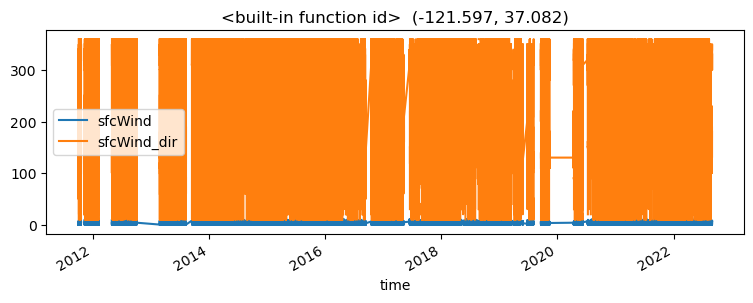

In [33]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_1.plot(ax=ax, x="time", y="sfcWind")
df_1.plot(ax=ax, x="time", y="sfcWind_dir")

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

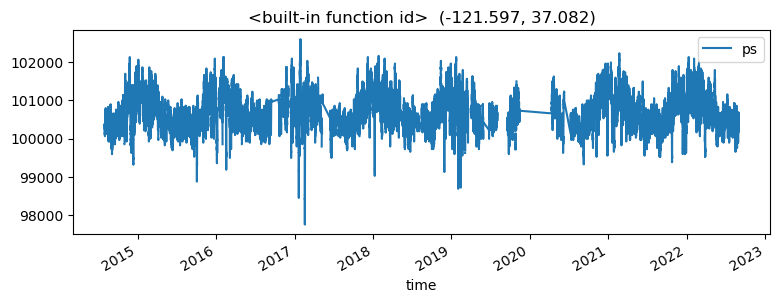

In [ ]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

#df_1.plot(ax=ax, x="time", y="pr")
df_1.plot(ax=ax, x="time", y="ps") 

# they likely removed the precip sensor
# pressure gap around 2019...should not be there, as pressure should never be zero. 
# - looks like sensor went down in 2019...confirem this. that all variables are zero
# - could make flag for when all varaibles are nans (ie station is down)

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

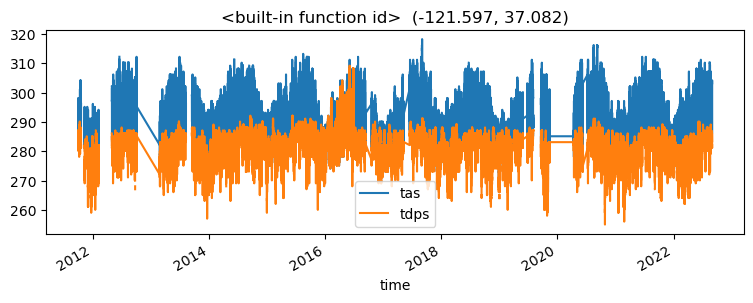

In [29]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_1.plot(ax=ax, x="time", y="tas")
df_1.plot(ax=ax, x="time", y="tdps")

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

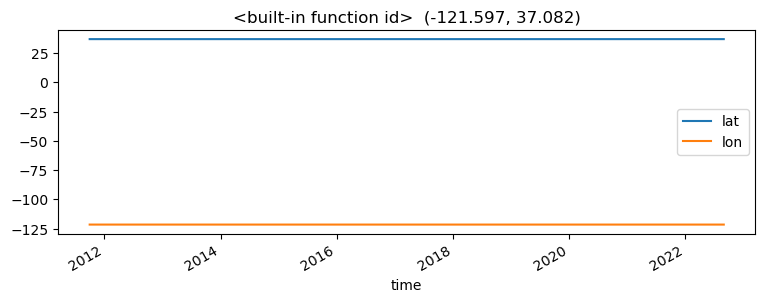

In [62]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_1.plot(ax=ax, x="time", y="lat")
df_1.plot(ax=ax, x="time", y="lon")

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Precipitation: gap between 1986 and 1997, with two recordings in that range. 


Air pressure (ps):  


All other meteorological variables are recorded near constantly across time.

### Station 2: ASOSAWOS_74509023244

In [29]:
df_2.columns

Index(['time', 'ps', 'tas', 'tdps', 'pr', 'sfcWind', 'sfcWind_dir',
       'elevation', 'qaqc_process', 'ps_qc', 'ps_altimeter', 'ps_altimeter_qc',
       'psl', 'psl_qc', 'tas_qc', 'tdps_qc', 'pr_qc', 'pr_duration',
       'pr_depth_qc', 'sfcWind_qc', 'sfcWind_method', 'sfcWind_dir_qc', 'lat',
       'lon', 'ps_eraqc', 'tas_eraqc', 'tdps_eraqc', 'pr_eraqc',
       'sfcWind_eraqc', 'sfcWind_dir_eraqc', 'elevation_eraqc',
       'ps_altimeter_eraqc', 'psl_eraqc', 'anemometer_height_m',
       'thermometer_height_m', 'station', 'hour', 'day', 'month', 'year',
       'date'],
      dtype='object')

In [30]:
lon = df_2.lon.mean()
lat = df_2.lat.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))

<built-in function id>, -122.04782, 37.41280


Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

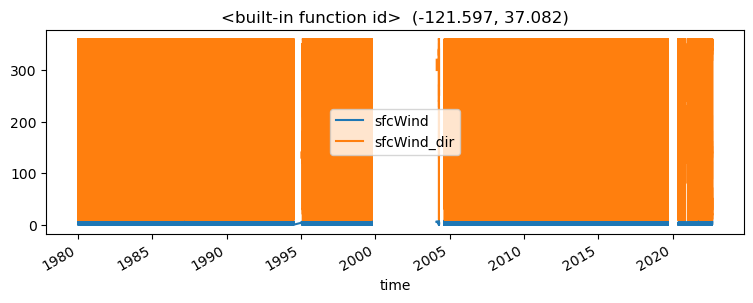

In [34]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_2.plot(ax=ax, x="time", y="sfcWind")
df_2.plot(ax=ax, x="time", y="sfcWind_dir")

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

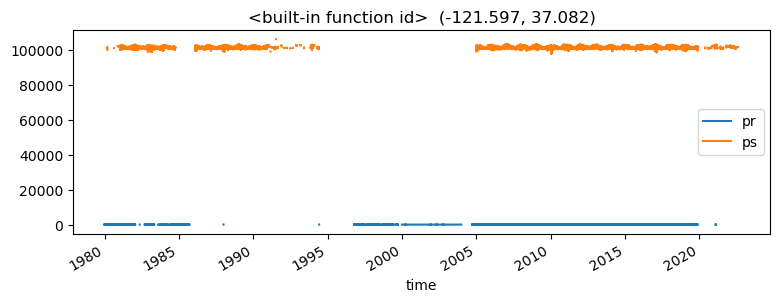

In [35]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_2.plot(ax=ax, x="time", y="pr")
df_2.plot(ax=ax, x="time", y="ps")

#that gap in pressure is worrying (pr does not), a decade is...quite a long time for 
# this sensor issue to NOT have been addressed. could be that the station got moved. 
# look into

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

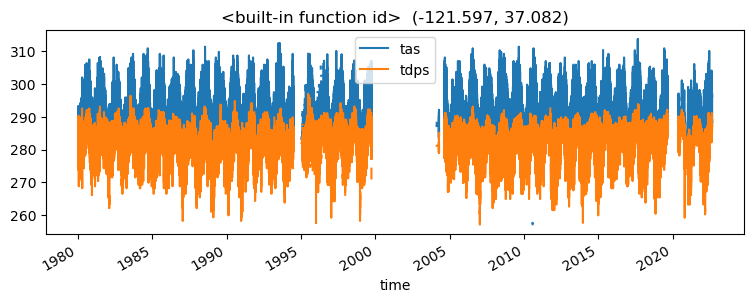

In [36]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_2.plot(ax=ax, x="time", y="tas")
df_2.plot(ax=ax, x="time", y="tdps")

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

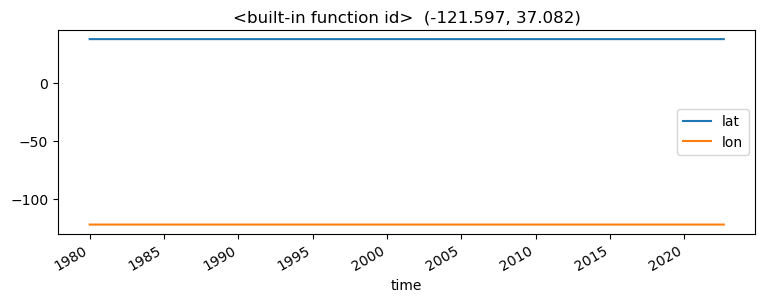

In [63]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_2.plot(ax=ax, x="time", y="lat")
df_2.plot(ax=ax, x="time", y="lon")

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Precipitation: gap between 1986 and 1997, with two recordings in that range. 


Air pressure (ps):  


All other meteorological variables are recorded near constantly across time.


### Station 3: ASOSAWOS_72494523293

In [34]:
lon = df_3.lon.mean()
lat = df_3.lat.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))

<built-in function id>, -121.92723, 37.36429


Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

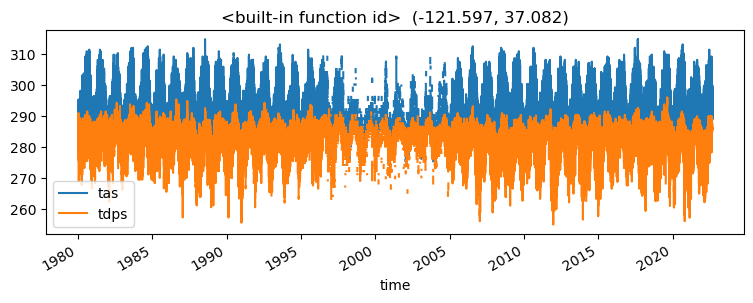

In [58]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_3.plot(ax=ax, x="time", y="tas")
df_3.plot(ax=ax, x="time", y="tdps")
ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

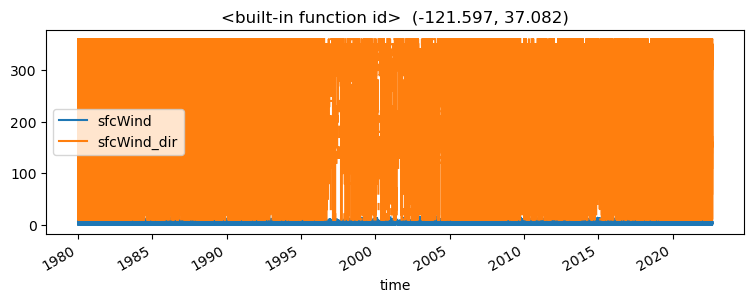

In [38]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_3.plot(ax=ax, x="time", y="sfcWind")
df_3.plot(ax=ax, x="time", y="sfcWind_dir")

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

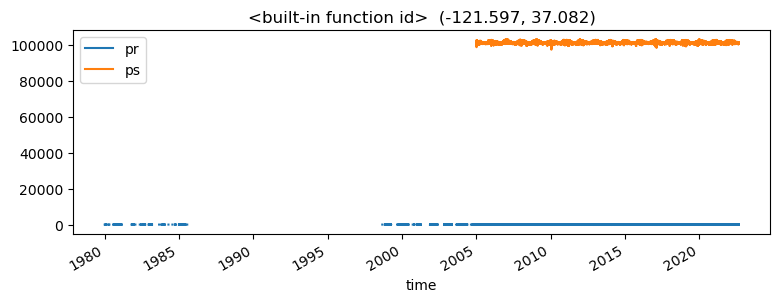

In [37]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_3.plot(ax=ax, x="time", y="pr")
df_3.plot(ax=ax, x="time", y="ps")

#this one looks...fine.
#look into first two stations

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

Text(0.5, 1.0, '<built-in function id>  (-121.597, 37.082)')

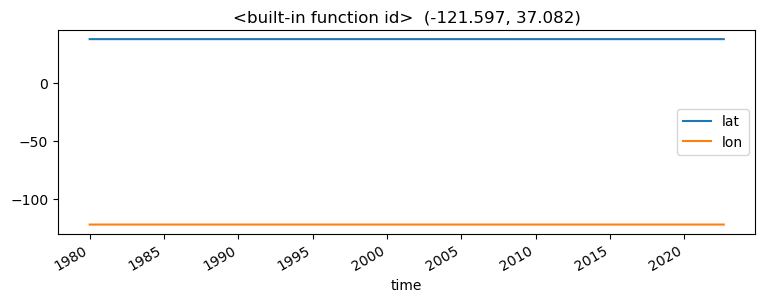

In [64]:
# Plot time series of the data 
fig,ax = plt.subplots(figsize=(9,3))

df_3.plot(ax=ax, x="time", y="lat")
df_3.plot(ax=ax, x="time", y="lon")

ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat))

There are notable data gaps in this station. 

## Identify stations that could be the “same”

### Make a map

In [36]:
# Run function - generate station map
def get_station_map(bucket_name, directory, shapepath, update = False):
    s3 = boto3.resource("s3") 
    s3_cl = boto3.client('s3')
    if update == False:
        obj = s3_cl.get_object(Bucket = bucket_name, Key = "2_clean_wx/temp_clean_all_station_list.csv")
        body = obj['Body'].read()
        dffull = pd.read_csv(BytesIO(body), encoding='utf8')
    elif update == True:
        dffull = get_station_list(bucket_name, directory)

    # Format dates in datetime format (this gets lost in import).
    # TODO: added format = 'mixed'
    dffull['start-date'] = pd.to_datetime(dffull['start-date'], utc = True,format = 'mixed')
    dffull['end-date'] = pd.to_datetime(dffull['end-date'], utc = True,format = 'mixed')

    # ------------------------------------------------------------------------------------------------------------
#     # Quality control (optional -- uncomment next 3 lines of code if desired)
#     # Filter out rows w/o start date - this will remove NDBC, MARITIME, CW3E networks (no date coverage in stn list)
#     subdf = dffull.loc[~dffull['start-date'].isnull()].copy()
#     # Filter out rows without data between 1980 and now.
#     subdf = subdf.loc[(subdf['start-date']<=datetime.utcnow().replace(tzinfo=timezone.utc)) 
#                       & (subdf['end-date']>='1980-01-01')]
    subdf = dffull
    
    # ------------------------------------------------------------------------------------------------------------
    # Make a geodataframe.
    gdf = gpd.GeoDataFrame(subdf, geometry=gpd.points_from_xy(subdf.longitude, subdf.latitude))
    gdf.set_crs(epsg=4326, inplace=True) # Set CRS
    
    # Project data to match base tiles.
    gdf_wm = gdf.to_crs(epsg=3857) # Web mercator

    # Read in geometry of continental US.
    us = gpd.read_file(shapepath)

    # Remove territories, AK, HI
    rem_list = ["HI", "AK", "MP", "GU", "AS", "PR", "VI"]
    us = us.loc[us.STUSPS.isin(rem_list) == False]

    # Use to clip stations
    us = us.to_crs(epsg = 3857)
    gdf_us = gdf_wm.clip(us)

    # ------------------------------------------------------------------------------------------------------------
    # Version 1 - full map
    ax = gdf_us.plot("network", figsize=(15, 15), alpha=1, markersize = 3, legend = True, cmap = 'nipy_spectral')
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    ax.set_axis_off()

    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)

    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key="2_clean_wx/clean_station_map.png")


    # ------------------------------------------------------------------------------------------------------------
    # Version 2 - only big networks
    # Sort stations by number of networks
    gdf_us['network_count'] = gdf_us.groupby('network')['network'].transform('count') # Add network count column.

    # If <100 stations, change to "misc"
    gdf_us.loc[gdf_us['network_count'] < 100, 'network'] = "Misc"

    # Plot
    ax = gdf_us.plot("network", figsize=(15, 15), alpha=1, markersize = 3, legend = True, cmap = 'nipy_spectral')
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron) 
    ax.set_axis_off()

    # Save to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)

    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key="2_clean_wx/clean_station_map_min.png")
        

### Find exact matches by WBAN, lat, lon

In [3]:
### Read in ASOSAWOS stations

s3_cl = boto3.client("s3")  # for lower-level processes

asosawos = s3_cl.get_object(
    Bucket="wecc-historical-wx", Key="1_raw_wx/ASOSAWOS/stationlist_ASOSAWOS.csv"
)
asosawos_list = pd.read_csv(BytesIO(asosawos["Body"].read()))

isd = s3_cl.get_object(
    Bucket="wecc-historical-wx", Key="1_raw_wx/ASOSAWOS/stationlist_ISD_ASOSAWOS.csv"
)
isd_list = pd.read_csv(BytesIO(isd["Body"].read()))


#print(asosawos_list) # 399 records (last two are nans)
print(isd_list) #457 records



     Unnamed: 0    USAF   WBAN                          STATION NAME CTRY  \
0             0  726810  24131   BOISE AIR TERMINAL/GOWEN FD AIRPORT   US   
1             1  726770  24033  BILLINGS LOGAN INTERNATIONAL AIRPORT   US   
2             2  726980  24229        PORTLAND INTERNATIONAL AIRPORT   US   
3             3  725690  24089       NATRONA COUNTY INTERNATIONAL AP   US   
4             4  722977  93184            J. WAYNE APT-ORANGE CO APT   US   
..          ...     ...    ...                                   ...  ...   
452         452  A07053    346                TRINITY CENTER AIRPORT   US   
453         453  A07049    320            PETALUMA MUNICIPAL AIRPORT   US   
454         454  A06854    115                 BIG BEAR CITY AIRPORT   US   
455         455  A00018  23162               DELTA MUNICIPAL AIRPORT   US   
456         456  A00028   4116            SALT LAKE CITY MUNI 2 ARPT   US   

    STATE  ICAO     LAT      LON  ELEV(M)     BEGIN       END        ISD-ID

In [25]:
# print(asosawos_list.columns)
# print(isd_list.columns)

# Try match on WBAN, lat, lon
# print(asosawos_list[['WBAN', 'LAT', 'LON']])
# print(isd_list[['WBAN', 'LAT', 'LON']])

      WBAN     LAT      LON
0    24131  43.567 -116.241
1    24033  45.807 -108.546
2    24229  45.596 -122.609
3    24089  42.898 -106.474
4    93184  33.680 -117.867
..     ...     ...      ...
452    346  40.983 -122.694
453    320  38.250 -122.600
454    115  34.264 -116.854
455  23162  39.383 -112.517
456   4116  40.619 -111.993

[457 rows x 3 columns]


In [4]:
### Round asosawos down to 3 decimal points of accuracy
asosawos_round = asosawos_list.round({"LAT": 3, "LON": 3})

In [5]:
### Try exact match first
join = isd_list.merge(
    asosawos_round,
    left_on=["WBAN", "LAT", "LON"],
    right_on=["WBAN", "LAT", "LON"],
    how="inner",
)
join  # 413 matches

missed = asosawos_list[~asosawos_list.NCDCID.isin(join.NCDCID)]
missed


,Unnamed: 0,NCDCID,WBAN,COOPID,CALL,NAME,ALTNAME,COUNTRY,ST,COUNTY,LAT,LON,ELEV,UTC,STNTYPE,STARTDATE,GHCN-DailyID,Barometer_elev,Anemometer_elev
170,170,20026585,94128,NaN,LGU,LOGAN CACHE AP,LOGAN CACHE AP,UNITED STATES,UT,CACHE,41.78650,-111.85188,1355.7504,-7,"AIRWAYS,ASOS",19981001.0,USW00094128,4447.0,33.0
202,202,20022624,24022,485415.0,LAR,LARAMIE AP,LARAMIE AP,UNITED STATES,WY,ALBANY,41.31650,-105.67288,2216.8104,-7,"ASOS,COOP,USHCN",20000928.0,USW00024022,7271.0,33.0
271,271,30002724,53143,NaN,SEE,GILLESPIE FLD AP,NaN,UNITED STATES,CA,SAN DIEGO,32.82611,-116.97250,117.9576,-8,"AIRWAYS,AWOS",NaN,NaN,NaN,NaN
284,284,20002130,23149,NaN,PTV,PORTERVILLE MUNI AP,NaN,UNITED STATES,CA,TULARE,36.02944,-119.06250,-30479.6952,-8,AWOS,NaN,NaN,NaN,NaN
335,335,30003010,4135,NaN,DIJ,DRIGGS-REED MEM AP,NaN,UNITED STATES,ID,TETON,43.74250,-111.09750,-30479.6952,-7,AWOS,NaN,NaN,NaN,NaN
349,349,30002243,3035,NaN,ATS,ARTESIA MUNI AP,NaN,UNITED STATES,NM,EDDY,32.85250,-104.46750,1079.2968,-7,AWOS,NaN,NaN,NaN,NaN
362,362,30002245,53127,NaN,HND,LAS VEGAS HENDERSON AP,NaN,UNITED STATES,NV,CLARK,35.97611,-115.13250,749.1984,-8,AWOS,NaN,NaN,NaN,NaN


In [72]:
# Run function - generate station map
def get_two_maps(subdf1, subdf2,shapepath):
    
    # ------------------------------------------------------------------------------------------------------------
    # Make a geodataframe.
    gdf1 = gpd.GeoDataFrame(subdf1, geometry=gpd.points_from_xy(subdf1.LON, subdf1.LAT))
    gdf2 = gpd.GeoDataFrame(subdf2, geometry=gpd.points_from_xy(subdf2.LON, subdf2.LAT))

    gdf1.set_crs(epsg=4326, inplace=True) # Set CRS
    gdf2.set_crs(epsg=4326, inplace=True) # Set CRS
    
    # Project data to match base tiles.
    gdf1_wm = gdf1.to_crs(epsg=3857) # Web mercator
    gdf2_wm = gdf2.to_crs(epsg=3857) # Web mercator

    # Read in geometry of continental US.
    us = gpd.read_file(shapepath)

    # Remove territories, AK, HI
    rem_list = ["HI", "AK", "MP", "GU", "AS", "PR", "VI"]
    us = us.loc[us.STUSPS.isin(rem_list) == False]

    # Use to clip stations
    us = us.to_crs(epsg = 3857)

    gdf1_us = gdf1_wm.clip(us)
    gdf2_us = gdf2_wm.clip(us)

    # ------------------------------------------------------------------------------------------------------------
    # Version 1 - full map
    ax1 = gdf1_us.plot('WBAN',figsize=(15, 15), alpha=1, markersize = 3, legend = True, cmap = 'nipy_spectral')
    ax2 = gdf2_us.plot('WBAN',figsize=(15, 15), alpha=1, markersize = 3, legend = True, cmap = 'nipy_spectral')
    cx.add_basemap(ax1, source=cx.providers.CartoDB.Positron)
    cx.add_basemap(ax2, source=cx.providers.CartoDB.Positron)
    ax1.set_axis_off()
    ax2.set_axis_off()


In [45]:
included_asosawos =  asosawos_list[asosawos_list.WBAN.isin(join.WBAN)]
included_isd =  isd_list[isd_list.WBAN.isin(join.WBAN)]

In [61]:
print(included_isd['WBAN'].sort_values())
unique_wbans = included_asosawos['WBAN'].unique()
len(unique_wbans) #393 matches, with a number of repeats

450      114
454      115
420      117
233      118
387      119
       ...  
303    94285
184    94297
381    94297
271    94298
321    94299
Name: WBAN, Length: 450, dtype: int64


393

In [ ]:
shapepath = "s3://wecc-historical-wx/0_maps/tl_2021_us_state"
get_two_maps(included_asosawos, included_isd, shapepath = shapepath)

### Find matches within a certain distance, of those missed by exact matching

In [ ]:
# stations not included in the exact matching above 

asosawos_missed = asosawos_round[~asosawos_round.WBAN.isin(join.WBAN)]
isd_missed = isd_list[~isd_list.WBAN.isin(join.WBAN)]


In [20]:
# Convert the data into GeoDataFrames
# using EPSG 3310

gdf_asosawos = gpd.GeoDataFrame(asosawos_missed, 
                        geometry=[Point(lon, lat) for lon, lat in zip(asosawos_missed['LON'], asosawos_missed['LAT'])],
                        crs="EPSG:4326").to_crs(epsg=3310)  

gdf_isd = gpd.GeoDataFrame(isd_missed, 
                        geometry=[Point(lon, lat) for lon, lat in zip(isd_missed['LON'], isd_missed['LAT'])],
                        crs="EPSG:4326").to_crs(epsg=3310)  

In [22]:
# Create a buffer around points in gdf1 (e.g., 10 km buffer)
gdf_asosawos['buffer'] = gdf_asosawos.geometry.buffer(.1)  # Buffer in degrees, 0.1 degrees approx equals 10 km

In [23]:
# Perform a spatial join using the buffer
# This will return rows from gdf_isd that are within the buffer distance from points in gdf_asosawos
merged = gpd.sjoin(gdf_isd, gdf_asosawos[['geometry', 'buffer']], how="inner", op="within")

# The 'merged' GeoDataFrame contains points from gdf_isd that are within the buffer around points in gdf_asosawos

/home/machuca/miniconda3/envs/hist-obs/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [ ]:
print(merged) # there are not ISD stations within 10km of an ASOSAWOS station missed by the exact matching

Empty GeoDataFrame
Columns: [Unnamed: 0, USAF, WBAN, STATION NAME, CTRY, STATE, ICAO, LAT, LON, ELEV(M), BEGIN, END, ISD-ID, start_time, end_time, Pulled, Time_Checked, geometry, index_right, buffer]
Index: []


## GHCN station matching code

In [74]:
# create geopandas dataframe of the two datasets we're comparing

asosawos_points = gpd.GeoDataFrame(
    index = asosawos_round.index,
    geometry = gpd.points_from_xy(asosawos_round['LON'], 
                                  asosawos_round['LAT'], 
                                  crs="EPSG:4326"
                                 ),
    data = {'era-id'   : asosawos_round['WBAN'],
            'longitude': asosawos_round['LON'],
            'latitude' : asosawos_round['LAT']
           }
).to_crs(epsg=3310)

isd_points = gpd.GeoDataFrame(
    index = isd_list.index,
    geometry = gpd.points_from_xy(isd_list['LON'], 
                                  isd_list['LAT'], 
                                  crs="EPSG:4326"
                                 ),
    data = {'id'   : isd_list['WBAN'],
            'longitude' : isd_list['LON'], 
            'latitude' : isd_list['LAT']
           }, 
).to_crs(epsg=3310)

In [78]:
## function to calculate the distance between points

def distance_sort_filter(row, df2, buffer=None, id=False):

    dist = df2.geometry.distance(row).sort_values()

    if buffer:
        dist = dist[dist<buffer]

    if id:
        distances = {df2.loc[idx]['WBAN']:value for idx,value in zip(dist.index, dist.values)}
    else:
        distances = {idx:value for idx,value in zip(dist.index, dist.values)}
    
    return distances

In [83]:
dist = asosawos_points.geometry.distance(isd_points['geometry'].iloc[2]).sort_values()

dist = dist[dist<1e4]

distances = {asosawos_points.loc[idx]['WBAN']:value for idx,value in zip(dist.index, dist.values)}

KeyError: 'WBAN'

In [80]:
dist_to_asosawos = isd_points['geometry'].transform(distance_sort_filter, df2=asosawos_points, buffer=1e4, id=True)
# isd_points['distance_to_asosawos'] = dist_to_asosawos
# isd_points

/home/machuca/miniconda3/envs/hist-obs/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


ValueError: Function did not transform

In [ ]:
ghcnh.stations_df.loc[5936:5936]
era_stations[era_stations['era-id']=='ASOSAWOS_72791894298']
- era-id = 'ASOSAWOS_72791894298' corresponds to Vancouver Airport
- Same for GHCN='USW00094298'

- The distance between ERA and GHCN is 19.21... meters:
    - Reporting lat and lon differs by decimals between the 2 databases
 
![Alt text](dist_to_era.png)
ghcn_points.loc[5936]['distance_to_era']

## Sandbox

In [ ]:
# load in single dc file from AWS

# key not recognized, abandoning this approach

ds_vw_1 = read_zarr_from_s3('VALLEYWATER', 'VALLEYWATER_6144', temp_dir) 
ds_vw_2 = read_zarr_from_s3('VALLEYWATER', 'VALLEYWATER_6053', temp_dir) 

#convert to formatted pandas dataframe
df_vw_1 = qaqc_ds_to_df(ds_1, verbose=False)
df_vw_2 = qaqc_ds_to_df(ds_2, verbose=False)
